In [1]:
import pandas as pd
import numpy as np
import pathlib

from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


In [2]:
base_path = pathlib.Path.cwd().parent
business_path = base_path.joinpath('data_lake/business/')
data = pd.read_csv(business_path.joinpath('precios-diarios.csv'), index_col=0) 
data.index = pd.to_datetime(data.index)

In [3]:
n_lags = 60

list_lags = [0] + list(range(1, n_lags))

df_lag = data.copy()
df_lags = pd.concat([df_lag.shift(shift) for shift in list_lags], axis=1)
df_lags = df_lags.dropna()
df_lags.columns = list_lags


In [4]:
X = df_lags.copy().drop(columns=[0])
y = df_lags.copy().iloc[:, [0]]


In [5]:
(X_train, X_test, y_train, y_test,) = train_test_split(X, y, test_size=0.3, random_state=123456,)

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)


StandardScaler()

In [27]:
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [28]:
pca = PCA(n_components=len(X_train_scaled.columns))
pca.fit(X_train_scaled)

PCA(n_components=59)

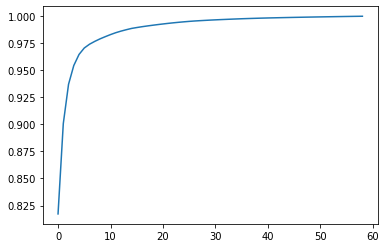

In [29]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [6]:
pipeline = Pipeline(
        steps=[
            # Paso 1: Construya un column_transformer que aplica StandardScaler a las
            # variables categóricas, y no aplica ninguna transformación al resto de
            # las variables.
            (
                "Standard",
                StandardScaler()
            ),
            # Paso 2: Construya un selector de características que seleccione las K
            # características más importantes. Utilice la función f_regression.
            (
                "PCA",
                PCA(n_components=10),
            ),
            # Paso 3: Construya un modelo de regresión.
            (
                "RandomForestRegressor",
                RandomForestRegressor(n_jobs = -1,random_state =1),
            ),
        ],
    )
param_grid = {
    'RandomForestRegressor__n_estimators': [200, 500],
    'RandomForestRegressor__max_features': ['auto', 'sqrt', 'log2'],
    }

gridSearchCV = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        refit=True,
        return_train_score=True,
    )

    # Búsque la mejor combinación de regresores
gridSearchCV.fit(X_train, y_train)



C:\Users\Mateo\AppData\Roaming\Python\Python310\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\Mateo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\Mateo\AppData\Roaming\Python\Python310\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\Mateo\AppData\Roaming\

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Standard', StandardScaler()),
                                       ('PCA', PCA(n_components=10)),
                                       ('RandomForestRegressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=1))]),
             param_grid={'RandomForestRegressor__max_features': ['auto', 'sqrt',
                                                                 'log2'],
                         'RandomForestRegressor__n_estimators': [200, 500]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [7]:
from sklearn.metrics import r2_score
r2_score(y_test,gridSearchCV.predict(X_test))

0.9652986907384822